# 1. 数の表現と誤差

## 概要

- コンピューターは、浮動小数点という形式のbit列で実数を表現している。
- 列の長さと計算時間が有限という制約から発生する誤差をまとめる

## Key-words

- float
- overflow, underflow
- absolute error, relative error
- rounding error
- 桁落ち
- 情報落ち
- 打ち切り誤差
- 離散化誤差

In [1]:
!python3 -V

Python 3.7.4


imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### [例題１]

2進数00101001を10進数で表せ

In [3]:
def binary_to_decimal(x):
    import re
    
    if not isinstance(x, str):
        raise ValueError('引数が文字列ではありません')
    condition_1 = re.findall('\D|[2-9]', x)
    
    if condition_1:
        print(condition_1)
        raise ValueError('引数に不正な文字列が入っています')
    
    res = 0
    length = len(x) - 1
    for i, j in enumerate(x):
        i = length - i
        res += int(j) * (2 ** (i))
        
    return res

In [4]:
binary_to_decimal('00101001')

41

In [5]:
def binary_to_decimal_2(x):
    import re
    if not isinstance(x, str):
        raise ValueError('引数が文字列ではありません')
    condition_1 = re.findall('\D|[2-9]', x)
    
    if condition_1:
        print(condition_1)
        raise ValueError('引数に不正な文字列が入っています')
    
    x = int(x)
    base = 0
    res = 0
    while x:
        digit = x % 10
        res += (2 ** base) * digit
        
        base += 1
        x = int(x / 10)
        
    return res

In [6]:
binary_to_decimal_2('00101001')

41

In [7]:
%%timeit -r 3 -n 1000
binary_to_decimal('00101001')

9.27 µs ± 1.87 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)


In [8]:
%%timeit -r 3 -n 1000
binary_to_decimal_2('00101001')

6.52 µs ± 124 ns per loop (mean ± std. dev. of 3 runs, 1000 loops each)


### [例題２]

10進数41を10進数で表せ

In [9]:
def decimal_to_binary(x):
    quotient, remainder = divmod(x, 2)
    res = str(remainder)
    while quotient > 0:
        quotient, remainder = divmod(quotient, 2)
        res = str(remainder) + res
    
    return res
    

In [10]:
decimal_to_binary(41)

'101001'

In [11]:
%%timeit -r 3 -n 1000
decimal_to_binary(41)

6.11 µs ± 1.65 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)


### [例題3]

2進数0.1100を10進数で表せ

In [12]:
def binary_to_decimalpoint(x, point = 7):
    """
    x should be smaller than 1 and positive 
    """
    eps = eval('1e-' + str(point - 1))
    base = 1
    res = 0
    while abs(x - 0) > eps:
        x = 10*x
        res += ((1/2)**base) * int(x)
        x = round(x -  int(x), point)
        base += 1
    
    return res

In [13]:
binary_to_decimalpoint(0.1100000)

0.75

In [14]:
%%timeit -r 3 -n 1000
binary_to_decimalpoint(0.1100)

22.6 µs ± 7.53 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)


### [例題4]

10進数0.6875を2進数で表せ

In [15]:
def decimal_to_binarypoint(x, iterator, point = 7):
    """
    x should be smaller than 1 and positive 
    """
    eps = eval('1e-' + str(point - 1))
    res = '0.'
    counter = 0
    while abs(x - 0) > eps and counter < iterator: 
        x = 2*x
        res += str(int(x))
        x = round(x - int(x), point)
        counter += 1
    
    return res

In [16]:
decimal_to_binarypoint(x = 0.6875, iterator = 7, point = 7)

'0.1011'

### 固定小数点, fixed-point number

- 浮動小数点数に比べて表現できる値の範囲ははるかに狭い
- 情報落ちが起こらない（そもそも情報落ちが起きるような差のある値は表現できない）ことや高速に演算できることが利点に挙げられる。
- 整数部、小数部、固定小数点で構成されている

### 浮動小数点(IEEE形式 32 bit)

- s: 符号, 1 bit
- m: 仮数部, 23 bit
- e: 指数部, 8 bit

$$
(-1)^s\times (1.m)_2\times 2^{e - 127}
$$

- $e \in (0, 255)$ then, $(-1)^s\times (1.m)_2\times 2^{e - 127}$
- $e = 255, m \neq 0$, NaN
- $e = 255, m = 0$, then $(-1)^s\times\infty$
- $e = 0, m \neq 0$, then $(-1)^s\times (0.m)_2\times 2^{e - 127}$

IEEE形式倍精度(64 bit)は

- s: 符号, 1 bit
- m: 仮数部, 52 bit
- e: 指数部, 11 bit

$$
(-1)^s\times (1.m)_2\times 2^{e - 1023}
$$

### オーバーフローとアンダーフロー

どちらもコンピューターによる数の表現範囲には限界があることに起因：

- オーバーフロー：数値の絶対値が表現可能な最大数を超える場合に発生
- アンダーフロー：数値の絶対値が表現可能な最小数より小さい場合に発生

### [例題5] 計算機イプシロンの確認

In [17]:
def machine_eps_checker():
    eps = 1
    while 1.0 + eps != 1.0:
        eps = eps/2
    return eps

In [18]:
machine_eps_checker()

1.1102230246251565e-16

### 誤差

```
絶対誤差 = abs(近似値 - 真の値)
相対誤差 = abs(近似値 - 真の値)/abs(真の値)
```

### 精度の桁数

$$
\text{精度の桁数} = - \log_{10}|\text{相対誤差}|
$$

### 誤差の原因

- 丸め誤差
- 桁落ち
- 情報落ち
- 打ち切り誤差
- 離散化誤差


### 丸め誤差
丸め誤差とは数値を有限ビット数で表現するため、最下位桁より小さい部分について四捨五入や切り上げ、切り捨てが行われ発生する誤差のこと。10進数0.1を二進数で表現すると循環小数となってしまい誤差が発生する。

### [例題6]
丸め誤差の一例を示す。

In [19]:
x = 0.0
while x != 1.0 and x < 2.0:
    x += 0.1
    print(x)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7
0.7999999999999999
0.8999999999999999
0.9999999999999999
1.0999999999999999
1.2
1.3
1.4000000000000001
1.5000000000000002
1.6000000000000003
1.7000000000000004
1.8000000000000005
1.9000000000000006
2.0000000000000004


- 丸め誤差との兼ね合いで、浮動小数点の比較で完全一致==, != は使ってはならないという原則がある。
- 上述のように丸め誤差が伝搬して大きな誤差となる場合もある

In [20]:
x = 0.0
i = 1
while x != 1.0 and x < 2.0:
    x = 0.1 * i
    i += 1
    print(x)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0


### REMARK
- 二進数で表現できる数を用いた加算を行うべきとされる


### 桁落ち

2つの浮動小数点数の大きさがほぼ等しく n 桁からなる仮数部のうち上位 k 桁が等しい場合を考える。2つの引き算を行うと上位k桁が打ち消して結果の仮数部には n - k 桁の情報しか残らないことになる。これを桁落ちという。

### [例題7] 桁落ちと有理化

$x$が0に近いとき、桁落ちしないように$\sqrt{x + 1} - 1$を計算せよ

#### 解

$$
\sqrt{x + 1} - 1 = \frac{x}{\sqrt{x + 1} + 1}
$$

In [21]:
x = -1e-7
root = (x + 1)**(1/2)
before = root - 1
after = x/(root + 1)

print(before, after)

-5.0000001250438686e-08 -5.000000125000006e-08


桁落ちの例として、

In [22]:
def log_error(y):
    try:
        return np.log(1 - y)/y
    except:
        return 0

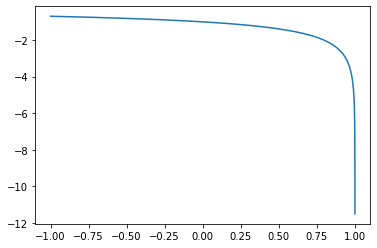

In [23]:
x = np.linspace(-1, 0.99999, 1000000)
y = log_error(x)
plt.plot(x, y);

x = 0近傍のplot

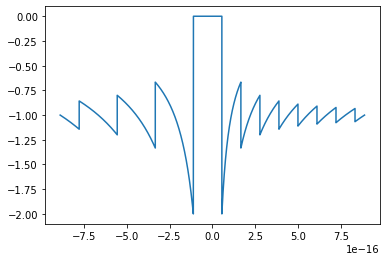

In [24]:
x = np.linspace(-2**(-50), 2**(-50), 1000000)
y = log_error(x)
plt.plot(x, y);

$\log(x)$の特徴としてxが1に近い場合、$x - 1$に近似されるので

In [25]:
def log_approx(x):
    return ((1-x)-1)/x

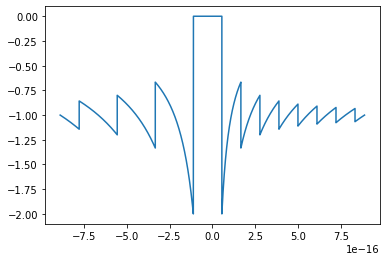

In [26]:
x = np.linspace(-2**(-50), 2**(-50), 1000000)
y = log_approx(x)
plt.plot(x, y);

桁落ちと情報落ちから発生するエラーの可視化

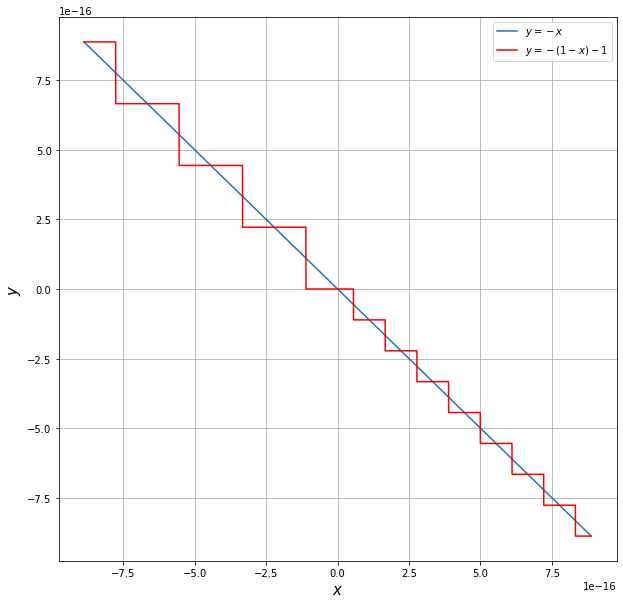

In [27]:
x = np.linspace(-2**(-50), 2**(-50), 1000000)

fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(x, -x, label = r'$y = - x$')
ax.plot(x,  (1- x) - 1, label = r'$y = - (1- x) - 1$', color = 'r')

ax.set_xlabel(r'$x$', fontsize=15)
ax.set_ylabel(r'$y$', fontsize=15)
ax.grid(True)

plt.legend(loc='upper right');

### 情報落ち

- 絶対値の非常に大きな数と小さな数の加減算を行ったとき、指数部が小さい方の数の仮数部の甲斐の部分が結果に反映されないために発生する誤差
- 指数部に合わせて、仮数部の桁ずらしを行なってから加減が実行される。従って両者の大きさが桁違いの場合、小さい方の情報が失われることは明らかである。この現象を情報落ちという
- 情報落ちは多数の数の加算(従って無限区間の積分など )には実際上の問題になる

In [28]:
x = 1e10
y = 1e-8

for i in range(10000000):
    x += y
print(x)

10000000000.0


### 打ち切り誤差

- 打ち切りごさは、無限回の演算を有限回で打ち切るときに発生する誤差
- フーリエ展開、ライプニッツの公式、バーゼル問題の数値計算が一例

### [例題8] ライプニッツの公式を証明せよ

$$
\frac{\pi}{4} = \sum_{k = 0}^\infty\frac{ (-1)^k}{2k + 1}
$$

#### 解
$$
\begin{align}
\frac{\pi}{4} &= \arctan(1) \\ &= \int_0^1 \frac 1{1+x^2} \, dx \\[8pt]
& = \int_0^1\left(\sum_{k=0}^n (-1)^k x^{2k}+\frac{(-1)^{n+1}\,x^{2n+2} }{1+x^2}\right) \, dx \  \ \because\text{ ここは等比数列}\\
& = \left(\sum_{k=0}^n \frac{(-1)^k}{2k+1}\right)
+(-1)^{n+1} \left(\int_0^1\frac{x^{2n+2}}{1+x^2} \, dx\right).
\end{align}
$$

Considering only the integral in the last line, we have:

$0 \le \int_0^1 \frac{x^{2n+2}}{1+x^2}\,dx \le \int_0^1 x^{2n+2}\,dx = \frac{1}{2n+3} \;\rightarrow 0 \text{ as } n \rightarrow \infty$

Therefore, by the squeeze theorem, as $n \to \infty$ we are left with the Leibniz series:

$$
\frac{\pi}4 = \sum_{k=0}^\infty\frac{(-1)^k}{2k+1}
$$

### バーゼル問題

$$
S_n = \sum^n_{i = 1} \frac{1}{i^2}
$$
を考える

$n \to \infty$の場合、

$$
\sum^\infty_{i = 1} \frac{1}{i^2}  = \frac{\pi^2}{6}
$$
が知られている（バーゼル問題）。Proof of sketchは以下、

$$
\sin x = x - \frac{1}{3!}x^3 + \frac{1}{5!}x^5 - \frac{1}{7!}x^7 + ....
$$

次に$\sin x$の因数分解をする。$n\pi$, (nは整数)の周期で$\sin n\pi = 0$となるので
$$
\begin{aligned}
\sin x = a \Pi_{n\text{は整数}}\  \ (x - n\pi) = ax \Pi_{n\text{は自然数(0は含めない)}} \  \ (x^2 - n^2\pi^2)
\end{aligned}
$$
有限時ならばaは最高次の項の係数であるが、今回は無限次なので、そのような考えは都合が悪い。そうすると

$$
x = a\left(\Pi(-n^2\pi^2)\right)x
$$

となると

$$
a = \Pi(-n^{-2}\pi^{-2})
$$
これを元の式に代入すると

$$
\sin x = x\Pi\left(1 - \frac{x^2}{n^2\pi^2}\right)
$$

3!の係数を比較すると

$$
\frac{1}{\pi^2}\left(\frac{1}{1^2} + \frac{1}{2^2} + \frac{1}{3^2} + ...\right) = \frac{1}{3!}
$$

結果、
$$
\sum^\infty_{i = 1} \frac{1}{i^2}  = \frac{\pi^2}{6}
$$

これを数値計算で表すと$1.6449340668...$となる。

### 離散化誤差

- （数値積分における台形公式、シンプソンの公式など、）連続関数の定積分の値を小さな台形の合計と捉えて数値計算することで発生する誤差

台形の公式は以下

$$
\begin{aligned}
&\int^b_a f(x) dx \approx \frac{b - a}{2n}\{ y_0 + 2(y_1 + y_2 + ... + y_{n - 1}) + y_n\}\\
&y_k = f(x_k), x_k = a + \frac{k(b - a)}{n} (k = 0, 1, ..., n)
\end{aligned}
$$

- 積分区間をn等分して、それぞれの区間の面積を台形の面積で近似する手法

### [例題9]
$$
\int_0^1 e^{-x^2} \, dx
$$
を台形の公式を用いて計算せよ

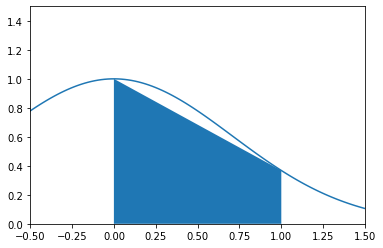

In [29]:
x = np.linspace(-0.5,1.5,100)
y = np.exp(-x**2)
plt.plot(x,y)

x0 = 0
x1 = 1
y0 = np.exp(-x0**2)
y1 = np.exp(-x1**2)

plt.fill_between([x0,x1],[y0,y1])

plt.xlim([-0.5,1.5]); plt.ylim([0,1.5]);

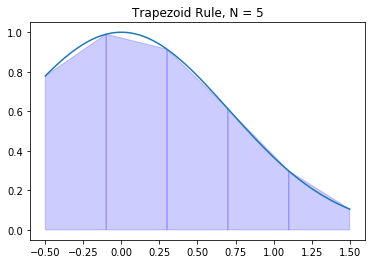

In [30]:
N = 5
x = np.linspace(-0.5,1.5,100)
y = np.exp(-x**2)
plt.plot(x,y)

X = np.linspace(-0.5,1.5, N + 1)
Y = np.exp(-X**2)


for i in range(N):
    xs = [X[i],X[i],X[i+1],X[i+1]]
    ys = [0,np.exp(-X[i]**2),np.exp(- X[i+1]**2),0]
    plt.fill(xs,ys,'b',edgecolor='b',alpha=0.2)

plt.title('Trapezoid Rule, N = {}'.format(N))
plt.show()

In [31]:
def trapz(f,a,b,N=50):
    '''
    Parameters
    ----------
    f : function
        Vectorized function of a single variable
    a , b : numbers
        Interval of integration [a,b]
    N : integer
        Number of subintervals of [a,b]

    Returns
    -------
    float
        Approximation of the integral of f(x) from a to b using the
        trapezoid rule with N subintervals of equal length.
    '''
    x = np.linspace(a,b,N+1) # N+1 points make N subintervals
    y = f(x)
    y_right = y[1:] # right endpoints
    y_left = y[:-1] # left endpoints
    dx = (b - a)/N
    T = (dx/2) * np.sum(y_right + y_left)
    return T

In [32]:
f = lambda x : np.exp(-x**2)
trapz(f, 0, 1)

0.7467996071893512

### Error formula theorem
the trapezoid rule
$$
T_N(f) = \frac{\Delta x}{2} \sum_{i=1}^N (f(x_i) + f(x_{i-1}))
$$
where $x_i = a + i \Delta x$ and $\Delta x = (b - a)/N$


Then,

$$
E_N^T(f) = \left| \ \int_a^b f(x) \ dx - T_N(f) \ \right| \leq \frac{(b-a)^3}{12 N^2} K_2
$$


where $\left| \ f''(x) \, \right| \leq K_2$ for all $x \in [a, b]$

### シンプソンの公式

- 台形公式よりも近似精度が良いとされる

$$
\begin{aligned}
&\int^b_a f(x)dx \approx \frac{b - a}{3n} \sum_{i = 1}^{n/2} y_{2i - 2} + 4y_{2i - 1} + y_{2i}\\
& y_i = f(x_i), x_i = a + \frac{k(b - a)}{n}, n \text{は偶数}
\end{aligned}
$$

#### 証明

シンプソンの公式は、$f(x)$を二次関数 $P(x)$ で近似することによって導かれる。ここで、$P(x)$は$f(x)$の a, b, m における値をそれぞれとる［m は“中点”、すなわち $(a+b)/2$］。$P(x)$ は、ラグランジュ補間によって、次の多項式（x の二次式）になることがわかる。

$$
P(x) = f(a) \frac{(x - m)(x - b)}{a - m)(a - b)} + f(m) \frac{(x - a)(x - b)}{m - a)(m - b)} + f(b) \frac{(x - a)(x - m)}{b - m)(b - m)}
$$

これを範囲$[a, b]$で積分すると、

$$
\int^b_a f(x)dx \approx \int^b_a P(x)dx =  \frac{b - a}{6} \left[f(a) + 4f\left(\frac{a + b}{2}\right) + f(b)\right]
$$

が得られる。積分範囲を小さな部分区間に分割し、各部分区間についてシンプソンの公式を適用し、その結果を足し合わせることで上の公式が得られる

なお、$f(x)$が3次式以下なら次式が成り立つ

$$
\frac{b - a}{6} \left[f(a) + 4f\left(\frac{a + b}{2}\right) + f(b)\right]
$$


証明は$f(x) = 1, x, x^2, x^3$でそれぞれで上の式が成り立つことを示せば良い。

#### (1) $f(x) = 1$

$$
\int^b_a f(x) = b - a 
$$

一方

$$
\frac{b - a}{6} \left[f(a) + 4\left(\frac{a + b}{2}\right) + f(b)\right] = \frac{b - a}{6} (1 + 4 + 1) = b - a
$$

#### (2) $f(x) = x$

$$
\int^b_a f(x) = \frac{1}{2}[b^2 - a^2] 
$$

一方

$$
\frac{b - a}{6} \left[a + 4\left(\frac{a + b}{2}\right) + b \right] = \frac{1}{2}(b - a)(a + b) = \frac{1}{2}[b^2 - a^2] 
$$

#### (3) $f(x) = x^2$

$$
\int^b_a f(x) = \frac{1}{3}[b^3 - a^3] 
$$

一方

$$
\frac{b - a}{6}[2a^2 + 2ab + 2b^2] = \frac{1}{3}(b^3 - a^3)
$$

#### (3) $f(x) = x^3$

$$
\int^b_a f(x) = \frac{1}{4}[b^4 - a^4] 
$$

一方

$$
\frac{b - a}{6} \left(a^3 + \frac{(a + b)^3}{2} + b^3\right) = \frac{b - a}{12}(3a^3 + 3b^3 + 3a^2b + 3ab^2) = \frac{1}{4}(b^4 - a^4)
$$

途中の計算は交代式


#### 交代式の因数分解

- 交代式とは，どの2つの変数を入れ替えても −1倍になるような式のことです。例えば $a^2−b^2$という式は，a と b を入れ替えると $b^2−a^2$ となり，元の式の −1 倍になるので交代式です。
- 対称式とは，どの2つの変数を入れ替えても元の値と変わらない式のこと

$$
a^4−b^4=(a−b)(a^3+a^2b+ab^2+b^3)
$$

$$
a^n+b^n=(a+b)(a^{n-1}-a^{n-2}b+\cdots-ab^{n-2}+b^{n-1})
$$


### [例題10] シンプソンの公式

シンプソンの公式を用いて、

$$
\int^1_0 3x^2 dx
$$

を計算せよ

In [33]:
def simp(f, a, b, N):
    '''
    Simpson's rule approximates the integral \int_a^b f(x) dx by the sum:
    (dx/3) \sum_{k=1}^{N/2} (f(x_{2i-2} + 4f(x_{2i-1}) + f(x_{2i}))
    where x_i = a + i*dx and dx = (b - a)/N.
    '''
    if N % 2 == 1:
        raise ValueError("N must be an even integer.")
    
    dx = (b-a)/N
    x = np.linspace(a,b,N+1) # 区間をN個
    y = f(x)
    S = dx/3 * np.sum(y[0:-1:2] + 4*y[1::2] + y[2::2])
    return S

In [34]:
simp(lambda x: 3*x**2, 0, 1, 50)

1.0

### 演習問題

#### [1 - 1]
2進数01101000を10進数で表せ

In [35]:
binary_to_decimal('01101000')

104

#### [1 - 2]
10進数72を2進数で表せ

In [36]:
decimal_to_binary(72)

'1001000'

#### [1-3]
2進数0.011を10進数であらわせ

In [37]:
binary_to_decimalpoint(0.011)

0.375

#### [1-4]
10進数0.3125を2進数で表せ

In [38]:
decimal_to_binarypoint(0.3125, iterator = 10)

'0.0101'

#### [2-2]
次のIEEE形式浮動小数点数が表す値を答えよ

```
1 01111111 10000000000000000000000
```

In [39]:
s = 1
e = 127 - 127
m = 1.5

print((-1 ** s) * (2 ** e) * m)

-1.5


#### [4 - 1]
IEEE単精度浮動小数点数で表される最大の数Mの10進法における桁数を求めよ

In [40]:
res = int(np.log(2.0 * (2 ** (254 - 127)))/ np.log(10)) + 1
print('10進法における桁数は{}'.format(res))

10進法における桁数は39


#### [6-1]

真の値3.141592に対して近似値が3.14であるとき絶対誤差、相対誤差、精度は何桁か？

In [41]:
true = 3.141592
approx = 3.14

abs_error = abs(approx - true)
relative_error = abs_error/true
precision = -np.log10(relative_error)

print(round(abs_error, 7), round(relative_error, 7), int(precision))

0.001592 0.0005067 3


#### [7] 二次方程式の解の公式と桁落ち対策

解の公式

$$
x = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a}
$$

をそのまま計算すると桁落ちのリスクがある。これを回避する手法を実装せよ。

#### [解]

```
INPUT
    a, b, c : 二次方程式の係数（xのorderが高い順で並べている）

OUTPUT
    x0, x1: 解
    
ALGORITHM
    1. x0 = [-b - sign(b)*sqrt(b^2 - 4ac)]/2a
    2. x1 = (c/a * x0)
    3. return x0, x1
```

In [42]:
def qeq(a, b, c):
    d = np.sqrt(b**2 - 4*a*c)
    alpha = (-b - np.sign(b)*d)/(2 * a)
    beta = c/(a * alpha)
    return (alpha, beta)

In [43]:
qeq(1, 5, 6)

(-3.0, -2.0)